Feature Extraction and Testing and Training set Creation.

In [1]:
import numpy as np 
import pandas as pd 
import librosa 
import os
from sklearn.model_selection import train_test_split
import sklearn
import librosa.display
import matplotlib.pyplot as plt

In [2]:
def plot(x, sr):
    # Waveplot
    plt.figure(figsize=(20, 5))
    plt.title("Waveplot")
    librosa.display.waveplot(x, sr = sr)

    # Spectrogram
    X = librosa.stft(x) # stft is Short time fourier transformation
    Xdb = librosa.amplitude_to_db(abs(X)) # Coverting amplitude to decibel
    plt.figure(figsize=(20, 5))
    plt.title("Spectrogram")
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

    # mfcc
    plt.figure(figsize=(20, 5))
    plt.title("MFCC")
    mfccs = librosa.feature.mfcc(x, sr = sr)
    librosa.display.specshow(mfccs, sr = sr, x_axis='time')

In [258]:

    # Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

    # Vocal channel (01 = speech, 02 = song).

    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

    # Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

    # Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

    # Repetition (01 = 1st repetition, 02 = 2nd repetition).

    # Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


We will traverse through all the files and create a data frame containg Actor,Gender, Emotion and File Path for each audio files. Then we will use this dataframe to go through all the file path and get the mean mfccs values for each audio file. This mfcc value extracted for each audio file is used to train the model based on emotion associated with each audio file. 

In [259]:
emotion=[]
gender=[]
actor=[]
file_path=[]
for i in os.listdir('./Audio'):
    # print(i)
    for j in os.listdir('./Audio/'+i):
        # print(j)
        part = j.split('.')[0].split('-')
        # print(part)
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        if int(part[6])%2:
            gender.append('male')
        else:
            gender.append("female")
        file_path.append('./Audio/' + i + '/' + j)

# A dataframe containing all emotion, gender, actor, path
new_df = pd.DataFrame(emotion)
new_df = new_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
new_df = pd.concat([pd.DataFrame(gender), new_df,pd.DataFrame(actor)], axis=1)
new_df.columns = ['gender','emotion','actor']
new_df = pd.concat([new_df, pd.DataFrame(file_path, columns = ['path'])],axis=1)
print(new_df)


      gender   emotion  actor                                       path
0       male   neutral      1  ./Audio/Actor_01/03-01-01-01-01-01-01.wav
1       male   neutral      1  ./Audio/Actor_01/03-01-01-01-01-02-01.wav
2       male   neutral      1  ./Audio/Actor_01/03-01-01-01-02-01-01.wav
3       male   neutral      1  ./Audio/Actor_01/03-01-01-01-02-02-01.wav
4       male      calm      1  ./Audio/Actor_01/03-01-02-01-01-01-01.wav
...      ...       ...    ...                                        ...
1435  female  surprise     24  ./Audio/Actor_24/03-01-08-01-02-02-24.wav
1436  female  surprise     24  ./Audio/Actor_24/03-01-08-02-01-01-24.wav
1437  female  surprise     24  ./Audio/Actor_24/03-01-08-02-01-02-24.wav
1438  female  surprise     24  ./Audio/Actor_24/03-01-08-02-02-01-24.wav
1439  female  surprise     24  ./Audio/Actor_24/03-01-08-02-02-02-24.wav

[1440 rows x 4 columns]


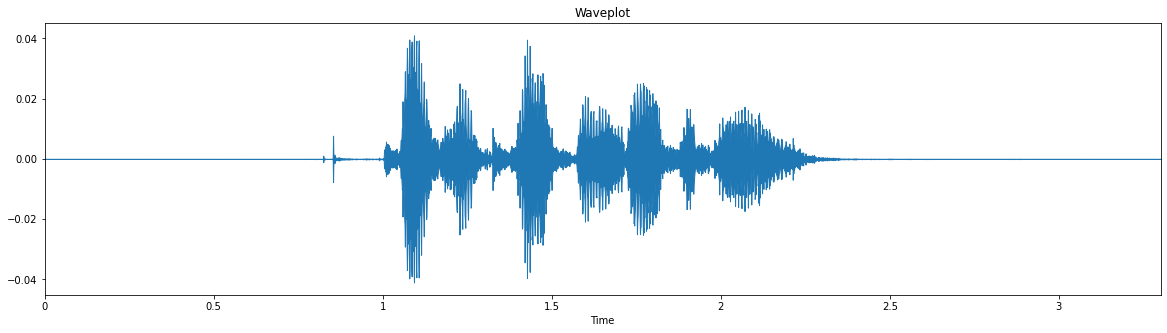

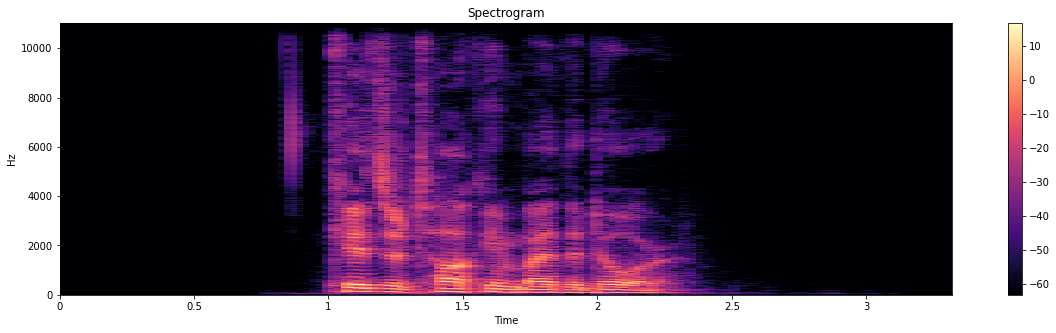

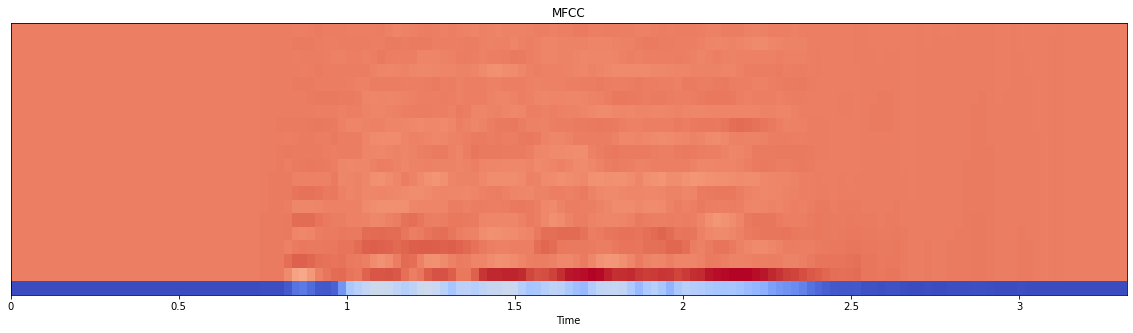

In [261]:
# Plot Waveform, Spectrogram, MFCC of First Audio
x, sr = librosa.load(new_df['path'][0])
plot(x, sr)

MFCC values for each audio file is extracted here. Generally, librosa.feature.mfcc returns us the mfcc of each audio file and is of shape 20 x 143 . So taking mean for each row using np.mean we get 20 mean mfcc values associated with each audio file. These 20 MFCC value will be used as training parameter.

In [260]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC
# New df with column name 'MFCC'
df = pd.DataFrame(columns=['MFCC'])
count=0
for path in audio_df.path:
    # Load audio and set the duration to 2.75sec so that we get MFCC array of same shape
    X, sample_rate = librosa.load(path, duration=2.75)
    # MFCC
    # n_fcc is for number of properties in MFCC array
    mfccs = librosa.feature.mfcc(X, sr = sample_rate, hop_length=512, n_mfcc=20)
    # Get the mean of columns
    mean = np.mean(mfccs.T, axis = 0)
    df.loc[count] = [mean]

    count = count+1
df.head()

,MFCC
0,"[-666.3476, 65.67248, -0.28546765, 14.705958, ..."
1,"[-657.2162, 67.10929, -2.6288135, 19.595482, 1..."
2,"[-661.5828, 68.86064, -0.46880877, 16.265572, ..."
3,"[-661.4031, 64.017494, 2.1174219, 14.93825, 7...."
4,"[-680.4659, 75.32324, 0.0764176, 17.657768, 8...."


In [262]:
df['MFCC'].shape, df['MFCC'][0].shape

((1440,), (20,))

There are 1440 audio files so we get total ((1440,),(20,)) total as our dataset.  Now we combine this df with existing data frame containing other details of audio files. As we are training on mfccs values so that acts as X(input parameter) based on it's corresponding emotions values so this will act as Y(output parameter). We have divided train and test data in 0.7 : 0.3 ratio. 

In [263]:
# df contains MFCC column and audio_df which contains other labels
combined_df = pd.concat([audio_df, df], axis=1)
print(combined_df)

# Dividing dataset in training and testing set
train_X, test_X, train_y, test_y = train_test_split(combined_df['MFCC'], combined_df['emotion'], test_size=0.3, random_state=0)
train_X
train_y

      gender   emotion  actor                                       path  \
0       male   neutral      1  ./Audio/Actor_01/03-01-01-01-01-01-01.wav   
1       male   neutral      1  ./Audio/Actor_01/03-01-01-01-01-02-01.wav   
2       male   neutral      1  ./Audio/Actor_01/03-01-01-01-02-01-01.wav   
3       male   neutral      1  ./Audio/Actor_01/03-01-01-01-02-02-01.wav   
4       male      calm      1  ./Audio/Actor_01/03-01-02-01-01-01-01.wav   
...      ...       ...    ...                                        ...   
1435  female  surprise     24  ./Audio/Actor_24/03-01-08-01-02-02-24.wav   
1436  female  surprise     24  ./Audio/Actor_24/03-01-08-02-01-01-24.wav   
1437  female  surprise     24  ./Audio/Actor_24/03-01-08-02-01-02-24.wav   
1438  female  surprise     24  ./Audio/Actor_24/03-01-08-02-02-01-24.wav   
1439  female  surprise     24  ./Audio/Actor_24/03-01-08-02-02-02-24.wav   

                                                   MFCC  
0     [-666.3476, 65.67248, -

1083     neutral
436        happy
1427     disgust
1403         sad
992        angry
          ...   
763         fear
835     surprise
1216       happy
559        happy
684          sad
Name: emotion, Length: 1008, dtype: object

In [264]:
# Normalize Data